In [1]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
import pandas as pd
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from Performance import performance_evaluation
perfs = performance_evaluation()

In [2]:
def Data_Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump):
    from Data import data_generation
    data_gen = data_generation()
    # W_star = data_gen.generate_truth(DataPath,lower, upper, p, d, coef_seed,data_generation_process) 
    # print("W_star = ",W_star[0,:])
    np.random.seed(coef_seed)
    np.random.seed(coef_seed)
    random.seed(coef_seed)
    seed_arr = random.sample(range(1, 10000 + 1), len(iteration_all))
    x_test_all = {}; c_test_all = {}; x_train_all = {}; c_train_all = {}; W_star_all = {}; noise_train_all = {}; noise_test_all = {}
    for iter in iteration_all:
        DataPath_iter = DataPath +"iter="+str(iter)+"/"
        pathlib.Path(DataPath_iter).mkdir(parents=True, exist_ok=True)
        W_star = data_gen.generate_truth(DataPath_iter,lower, upper, p, d, seed_arr[iter],data_generation_process) 
        x_test_all[iter], c_test_all[iter], x_train_all[iter], c_train_all[iter], noise_train_all[iter],noise_test_all[iter],W_star_all[iter] \
        = data_gen.generate_samples(iter,DataPath_iter,p, d, num_test, num_train, alpha, W_star, mis, num_test, data_generation_process, x_dist, e_dist, x_low, x_up, x_mean, x_var, bump) 
    return x_test_all, c_test_all, x_train_all, c_train_all, noise_train_all,noise_test_all,W_star_all

In [3]:
def Implement_Oracle(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,iteration_all,num_feat,data_generation_process):
    cost_Oracle_Post = {}; cost_Oracle_Ante = {}
    for iter in iteration_all:
        if data_generation_process == "SPO_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
            cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
            # cost_Oracle_Post[iter] = perfs.compute_SPO_out_of_sample_Cost_Ex_Post(arcs, grid,cost_oracle_pred,cost_oracle_pred,noise_test_all[iter])
            cost_Oracle_Ante[iter] = perfs.compute_SPO_out_of_sample_Cost_Ex_Ante(arcs, grid,cost_oracle_pred,cost_oracle_pred)
            # print("Oracle: iter=",iter,",cost_Oracle_Post=",np.nanmean(cost_Oracle_Post[iter]),",cost_Oracle_Ante=",np.nanmean(cost_Oracle_Ante[iter]))

        if data_generation_process == "DDR_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
            cost_oracle_pred = (cost_oracle_ori ** mis).T
            cost_Oracle_Post[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_oracle_pred,cost_oracle_pred,noise_test_all[iter],True)
            cost_Oracle_Ante[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_oracle_pred,cost_oracle_pred,noise_test_all[iter],False)
            # print("Oracle: iter=",iter,",cost_Oracle_Post=",np.nanmean(cost_Oracle_Post[iter]),",cost_Oracle_Ante=",np.nanmean(cost_Oracle_Ante[iter]))
        if iter % 20 == 0 and iter > 0:
            # print("Oracle: iter=",iter,",cost_Oracle_Post=",np.nanmean(cost_Oracle_Post[iter]),",cost_Oracle_Ante=",np.nanmean(cost_Oracle_Ante[iter]))
            print("Oracle: iter=",iter,",cost_Oracle_Ante=",np.nanmean(cost_Oracle_Ante[iter]))
    return cost_Oracle_Post,cost_Oracle_Ante

In [4]:
def Implement_OLS(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process):
    from OLS import ols_method
    ols_method_obj = ols_method()
    W_ols_all = {}; w0_ols_all = {}; t_ols_all = {}; obj_ols_all = {}
    cost_OLS_Post = {}; cost_OLS_Ante = {}
    for iter in iteration_all:
        # compute OLS performance
        W_ols_all[iter], w0_ols_all[iter], t_ols_all[iter], obj_ols_all[iter] = ols_method_obj.ols_solver("",x_train_all[iter], c_train_all[iter])
        cost_dem = (W_ols_all[iter] @ x_test_all[iter].T).T + w0_ols_all[iter]

        if data_generation_process == "SPO_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
            cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
            # cost_OLS_Post[iter] = perfs.compute_SPO_out_of_sample_Cost_Ex_Post(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter])
            cost_OLS_Ante[iter] = perfs.compute_SPO_out_of_sample_Cost_Ex_Ante(arcs, grid,cost_dem,cost_oracle_pred)
            # print("Oracle: iter=",iter,",cost_OLS_Post=",np.nanmean(cost_OLS_Post[iter]),",cost_OLS_Ante=",np.nanmean(cost_OLS_Ante[iter]))

        if data_generation_process == "DDR_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
            cost_oracle_pred = (cost_oracle_ori ** mis).T
            cost_OLS_Post[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter],True)
            cost_OLS_Ante[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter],False)
        if iter % 20 == 0 and iter > 0:
            # print("OLS: iter=",iter,",cost_OLS_Post =",np.nanmean(cost_OLS_Post[iter]),",cost_OLS_Ante=",np.nanmean(cost_OLS_Ante[iter]))
            print("OLS: iter=",iter,",cost_OLS_Ante=",np.nanmean(cost_OLS_Ante[iter]))
    return cost_OLS_Post,cost_OLS_Ante

In [5]:
def Implement_DDR(mu_all,lamb_all,arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process):
    from DDR import DDR_method
    ddr_object = DDR_method()
    num_nodes = grid[0] * grid[0]

    w0_ddr_dict = {}; W_ddr_dict = {}
    cost_DDR_Post = {}; cost_DDR_Ante = {}
    for iter in iteration_all:
        for mu in mu_all:
            for lamb in lamb_all:
                w0_ddr_dict[iter,mu,lamb],W_ddr_dict[iter,mu,lamb],alpha_rst,obj_ddr = ddr_object.solve_DDR(arcs,lamb,mu,num_nodes,x_train_all[iter],c_train_all[iter])
                cost_pred = (W_ddr_dict[iter,mu,lamb] @ x_test_all[iter].T).T + w0_ddr_dict[iter,mu,lamb]
                if data_generation_process == "SPO_Data_Generation":
                    cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
                    cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
                    # cost_DDR_Post[iter,mu,lamb] = perfs.compute_SPO_out_of_sample_Cost_Ex_Post(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter])
                    cost_DDR_Ante[iter,mu,lamb] = perfs.compute_SPO_out_of_sample_Cost_Ex_Ante(arcs, grid,cost_pred,cost_oracle_pred)

                if data_generation_process == "DDR_Data_Generation":
                    cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
                    cost_oracle_pred = (cost_oracle_ori ** mis).T
                    # cost_DDR_with_noise_all[iter,mu,lamb] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],True)
                    cost_DDR_Ante[iter,mu,lamb] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],False)
        if iter % 20 == 0 and iter > 0:
            # print("DDR: iter=",iter,",mu=",mu,",lamb=",lamb,",cost_DDR_Post =",np.nanmean(cost_DDR_Post[iter,mu,lamb]),
            #       ",cost_DDR_Ante =",np.nanmean(cost_DDR_Ante[iter,mu,lamb]))
            print("DDR: iter=",iter,",mu=",mu,",lamb=",lamb,",cost_DDR_Ante =",np.nanmean(cost_DDR_Ante[iter,mu,lamb]))
    return cost_DDR_Post,cost_DDR_Ante

In [6]:
def Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
                  arcs,grid,epo_runner,perfs,num_feat,mis,data_generation_process):
    W_EPO_all = {}; w0_EPO_all = {}
    cost_EPO_Post = {}; cost_EPO_Ante = {}
    for iter in iteration_all:
        DataPath_seed = DataPath +"iter="+str(iter)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        W_EPO_all[iter],w0_EPO_all[iter] = epo_runner.run(method_names,DataPath_seed,batch_size,num_feat,grid,num_epochs,\
                                        x_train_all[iter],c_train_all[iter],arcs)
        
        cost_pred = (W_EPO_all[iter] @ x_test_all[iter].T).T + w0_EPO_all[iter]
        if data_generation_process == "SPO_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
            non_negative_cols = (cost_oracle_ori > 0).all(axis=0)
            cost_oracle_ori = cost_oracle_ori[:,non_negative_cols]
            cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
            
            cost_pred = cost_pred[non_negative_cols,:]
            # cost_EPO_Post[iter] = perfs.compute_SPO_out_of_sample_Cost_Ex_Post(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter])
            cost_EPO_Ante[iter] = perfs.compute_SPO_out_of_sample_Cost_Ex_Ante(arcs, grid,cost_pred,cost_oracle_pred)

        if data_generation_process == "DDR_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
            cost_oracle_pred = (cost_oracle_ori ** mis).T
            cost_EPO_Ante[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],False)
            cost_EPO_Post[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],True)

        if iter % 20 == 0 and iter > 0:
            # print(method_names,": iter=",iter,",cost_EPO_Post =",np.nanmean(cost_EPO_Post[iter]),",cost_EPO_Ante=",np.nanmean(cost_EPO_Ante[iter]))
            print(method_names,": iter=",iter,",cost_EPO_Ante=",np.nanmean(cost_EPO_Ante[iter]))
    return cost_EPO_Post,cost_EPO_Ante

In [7]:
def store_input_data(DataPath,x_test_all,c_test_all,x_train_all,c_train_all,noise_test_all,noise_train_all,W_star_all):
        with open(DataPath+'x_test_all.pkl', "wb") as tf:
            pickle.dump(x_test_all,tf)
        with open(DataPath+'c_test_all.pkl', "wb") as tf:
            pickle.dump(c_test_all,tf)
        with open(DataPath+'x_train_all.pkl', "wb") as tf:
            pickle.dump(x_train_all,tf)
        with open(DataPath+'c_train_all.pkl', "wb") as tf:
            pickle.dump(c_train_all,tf)
        with open(DataPath+'noise_train_all.pkl', "wb") as tf:
            pickle.dump(noise_train_all,tf)
        with open(DataPath+'noise_test_all.pkl', "wb") as tf:
            pickle.dump(noise_test_all,tf)
        with open(DataPath+'W_star_all.pkl', "wb") as tf:
            pickle.dump(W_star_all,tf)

In [8]:
def load_cost_data(DataPath):
    with open(DataPath+'cost_OLS_Post_all.pkl', "rb") as tf:
        cost_OLS_Post_all = pickle.load(tf)
    with open(DataPath+'cost_OLS_Ante_all.pkl', "rb") as tf:
        cost_OLS_Ante_all = pickle.load(tf)

    with open(DataPath+'cost_Oracle_Post_all.pkl', "rb") as tf:
        cost_Oracle_Post_all = pickle.load(tf)
    with open(DataPath+'cost_Oracle_Ante_all.pkl', "rb") as tf:
        cost_Oracle_Ante_all = pickle.load(tf)

    with open(DataPath+'cost_DDR_Post_all.pkl', "rb") as tf:
        cost_DDR_Post_all = pickle.load(tf)
    with open(DataPath+'cost_DDR_Ante_all.pkl', "rb") as tf:
        cost_DDR_Ante_all = pickle.load(tf)

    return cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all

In [9]:
def run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process):
        with open(DataPath+'x_test_all.pkl', "rb") as tf:
            x_test_all = pickle.load(tf)
        with open(DataPath+'c_test_all.pkl', "rb") as tf:
            c_test_all = pickle.load(tf)
        with open(DataPath+'x_train_all.pkl', "rb") as tf:
            x_train_all = pickle.load(tf)
        with open(DataPath+'c_train_all.pkl', "rb") as tf:
            c_train_all = pickle.load(tf)
        with open(DataPath+'noise_train_all.pkl', "rb") as tf:
            noise_train_all = pickle.load(tf)
        with open(DataPath+'noise_test_all.pkl', "rb") as tf:
            noise_test_all = pickle.load(tf)
        with open(DataPath+'W_star_all.pkl', "rb") as tf:
            W_star_all = pickle.load(tf)

        cost_Oracle_Post_all,cost_Oracle_Ante_all = Implement_Oracle(arcs, grid,mis,bump,\
                                                                    W_star_all,x_test_all,noise_test_all,\
                                                                    iteration_all,num_feat,data_generation_process)

        cost_OLS_Post_all,cost_OLS_Ante_all = Implement_OLS(arcs, grid,mis,bump,\
                                                            W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,\
                                                            iteration_all,num_feat,data_generation_process)

        cost_DDR_Post_all,cost_DDR_Ante_all = Implement_DDR(mu_all,lamb_all,arcs, grid,mis,bump,\
                                                                    W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,\
                                                                        iteration_all,num_feat,data_generation_process)

        # batch_size = 20
        # num_epochs = 1000
        # from PYEPO import PyEPO_Method
        # epo_runner = PyEPO_Method()
        # method_names = ["spo+"]
        # cost_SPO_Post_all,cost_SPO_Ante_all = Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,\
        #                                             W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
        #                                             arcs,grid,epo_runner,perfs,num_feat,mis,data_generation_process)

        
        with open(DataPath+'cost_Oracle_Post_all.pkl', "wb") as tf:
            pickle.dump(cost_Oracle_Post_all,tf)
        with open(DataPath+'cost_Oracle_Ante_all.pkl', "wb") as tf:
            pickle.dump(cost_Oracle_Ante_all,tf)

        with open(DataPath+'cost_OLS_Post_all.pkl', "wb") as tf:
            pickle.dump(cost_OLS_Post_all,tf)
        with open(DataPath+'cost_OLS_Ante_all.pkl', "wb") as tf:
            pickle.dump(cost_OLS_Ante_all,tf)

        with open(DataPath+'cost_DDR_Post_all.pkl', "wb") as tf:
            pickle.dump(cost_DDR_Post_all,tf)
        with open(DataPath+'cost_DDR_Ante_all.pkl', "wb") as tf:
            pickle.dump(cost_DDR_Ante_all,tf)

In [10]:
def cross_compare2plus(c_item, c_base, c_oracle):
    N = len(c_item)
    c_diff = c_base - c_item
    lbel = np.zeros((N,1))
    
    equals = np.sum(c_diff == 0)
    wins = np.sum(c_diff > 0) # indicate num of c_item is lower than c_base
    lose = np.sum(c_diff < 0)
    
    lbel[c_diff < 0] = 1
    lbel[c_diff > 0] = -1
    
#     print(N, equals, wins, lose)
    if N == equals:
        win_ratio = 0.5
    else:
        win_ratio = wins/(N - equals)
    cost_reduction = (np.nanmean(c_diff))/np.abs(np.nanmean(c_base))
    if np.nanmean(c_base) - np.nanmean(c_oracle) <= 1e-6:
        regret_reduction = 0.0
    else:
        regret_reduction = (np.nanmean(c_diff))/np.abs(np.nanmean(c_base) - np.nanmean(c_oracle))
    return win_ratio, cost_reduction, regret_reduction

In [23]:
def calculate_h2h_regret(mu,lamb,iteration_all,cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all):
    ### Post Result
    h2h_ = np.zeros(len(iteration_all)); cost_rd_ = np.zeros(len(iteration_all)); regret_rd_ = np.zeros(len(iteration_all))
    # for iter_index in range(len(iteration_all)):
    #     iter = iteration_all[iter_index]
    #     h2h_[iter_index],cost_rd_[iter_index],regret_rd_[iter_index] = cross_compare2plus(cost_DDR_Post_all[iter,mu,lamb], cost_OLS_Post_all[iter], cost_Oracle_Post_all[iter])
    # regret_post = np.round( len(regret_rd_[regret_rd_ > 0.0])/len(regret_rd_),4 )
    # h2h_post = np.round( len(h2h_[h2h_ >= 0.5])/len(h2h_),4 )

    ### Ante Result
    h2h_ = np.zeros(len(iteration_all)); cost_rd_ = np.zeros(len(iteration_all)); regret_rd_ = np.zeros(len(iteration_all))
    for iter_index in range(len(iteration_all)):
        iter = iteration_all[iter_index]
        h2h_[iter_index],cost_rd_[iter_index],regret_rd_[iter_index] = cross_compare2plus(cost_DDR_Ante_all[iter,mu,lamb], cost_OLS_Ante_all[iter], cost_Oracle_Ante_all[iter])
    regret_ante = np.round( len(regret_rd_[regret_rd_ > 0.0])/len(regret_rd_),4 )
    h2h_ante = np.round( len(h2h_[h2h_ >= 0.5])/len(h2h_),4 )
    # return h2h_post,regret_post,h2h_ante,regret_ante
    return h2h_ante,regret_ante

### Parameters

In [12]:
grid = (2,2) # grid size
from Network import network_design
Network = network_design()
arcs,arc_index_mapping = Network._getArcs(grid)

num_test = 1000
lower = 0 # coef lower bound
upper = 1 # coef upper bound
d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
num_nodes = grid[0]*grid[0]
coef_seed = 1

x_dist = 'uniform'
e_dist = 'normal'
x_low = -2
x_up = 2
x_mean = 2
x_var = 2
bump = 100

In [13]:
data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
project_directory = os.path.dirname(os.path.dirname(os.path.dirname(parent_directory)))
DataPath_Parent = project_directory + f'/Data_JOC_R1/Shortest_Path/Various_Settings_coef_seed={coef_seed}/{grid[0]}by{grid[1]}_Network_' + data_generation_process + "/"
pathlib.Path(DataPath_Parent).mkdir(parents=True, exist_ok=True)
print("DataPath_parent:", DataPath_Parent)

DataPath_parent: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_coef_seed=1/2by2_Network_SPO_Data_Generation/


#### Impact of sample size

In [14]:
num_feat = 5 # size of feature
p = num_feat
deg = 1.0 # polynomial degree
mis = deg # model misspecification
e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term
iteration_all = np.arange(0,100)
batch_size = 20
num_epochs = 1000
num_train_all = [50,100,200,500,1000]
mu_all = np.asarray([0.5])
lamb_all = np.asarray([0.3])
for num_train in num_train_all:
    DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
    print("DataPath:", DataPath)
    
    x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all \
    = Data_Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

    store_input_data(DataPath,x_test_all,c_test_all,x_train_all,c_train_all,noise_test_all,noise_train_all,W_star_all)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_coef_seed=1/2by2_Network_SPO_Data_Generation/data_size=50_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_coef_seed=1/2by2_Network_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_coef_seed=1/2by2_Network_SPO_Data_Generation/data_size=200_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_coef_seed=1/2by2_Network_SPO_Data_Generation/data_size=500_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Re

In [15]:
for num_train in num_train_all:
    DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    print("DataPath:", DataPath)
    run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_coef_seed=1/2by2_Network_SPO_Data_Generation/data_size=50_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13
Oracle: iter= 20 ,cost_Oracle_Ante= 7.570987910337144
Oracle: iter= 40 ,cost_Oracle_Ante= 7.633024984495525
Oracle: iter= 60 ,cost_Oracle_Ante= 7.681466558473392
Oracle: iter= 80 ,cost_Oracle_Ante= 7.5372654068001035
OLS: iter= 20 ,cost_OLS_Ante= 7.712084158320866
OLS: iter= 40 ,cost_OLS_Ante= 7.810012085386832
OLS: iter= 60 ,cost_OLS_Ante= 7.694011667498538
OLS: iter= 80 ,cost_OLS_Ante= 7.608629547109129
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_Ante = 7.713483682866974
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_Ante = 7.816434870700436
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_Ante = 7.69396847606451
DDR: iter= 80 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_Ante = 7.6079716

In [25]:
regret_N_post = np.zeros(len(num_train_all)); h2h_N_post = np.zeros(len(num_train_all))
regret_N_ante = np.zeros(len(num_train_all)); h2h_N_ante = np.zeros(len(num_train_all))
mu = mu_all[0]
lamb = lamb_all[0]
_index = 0
for num_train in num_train_all:
    DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    print(DataPath)
    
    cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = load_cost_data(DataPath)
    
    # h2h_N_post[_index],regret_N_post[_index], h2h_N_ante[_index], regret_N_ante[_index] = calculate_h2h_regret(mu,lamb,iteration_all,\
    #                      cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
    #                         cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
    h2h_N_ante[_index], regret_N_ante[_index] = calculate_h2h_regret(mu,lamb,iteration_all,\
                         cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                            cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
    _index = _index + 1

/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_coef_seed=1/2by2_Network_SPO_Data_Generation/data_size=50_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_coef_seed=1/2by2_Network_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_coef_seed=1/2by2_Network_SPO_Data_Generation/data_size=200_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Settings_coef_seed=1/2by2_Network_SPO_Data_Generation/data_size=500_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Various_Set

#### Impact of number of feature

In [ ]:
deg = 1.0 # polynomial degree
mis = deg # model misspecification
e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term
num_train = 100
num_feat_all = [1,3,5,7,10,15]
for num_feat in num_feat_all:
    p = num_feat
    if p != 5:
        DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)

        x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all \
        = Data_Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

        store_input_data(DataPath,x_test_all,c_test_all,x_train_all,c_train_all,noise_test_all,noise_train_all,W_star_all)

In [ ]:
for num_feat in num_feat_all:
    p = num_feat
    if p != 5:
        DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)        
        run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

In [ ]:
regret_P_post = np.zeros(len(num_feat_all)); h2h_P_post = np.zeros(len(num_feat_all))
regret_P_ante = np.zeros(len(num_feat_all)); h2h_P_ante = np.zeros(len(num_feat_all))
mu = mu_all[0]
lamb = lamb_all[0]
_index = 0
for num_feat in num_feat_all:
    p = num_feat
    DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    print("DataPath:", DataPath)        

    cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = load_cost_data(DataPath)
    
    h2h_P_post[_index],regret_P_post[_index], h2h_P_ante[_index], regret_P_ante[_index] = calculate_h2h_regret(mu,lamb,iteration_all,\
                         cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                            cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
    _index = _index + 1

#### Impact of alpha

In [ ]:
deg = 1.0 # polynomial degree
mis = deg # model misspecification
num_train = 100
num_feat = 5
p = num_feat
e_all = [0.25,0.5,0.75,1.0]
for e in e_all:
    alpha = e # scale of normal std or the range of uniform. For the error term
    if e != 0.5:
        DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)
        x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all \
        = Data_Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

        store_input_data(DataPath,x_test_all,c_test_all,x_train_all,c_train_all,noise_test_all,noise_train_all,W_star_all)

In [ ]:
for e in e_all:
    alpha = e 
    if e != 0.5:
        DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
        print("DataPath:", DataPath)
        run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

In [ ]:
regret_e_post = np.zeros(len(e_all)); h2h_e_post = np.zeros(len(e_all))
regret_e_ante = np.zeros(len(e_all)); h2h_e_ante = np.zeros(len(e_all))
mu = mu_all[0]
lamb = lamb_all[0]
_index = 0
for e in e_all:
    alpha = e 
    DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    print("DataPath:", DataPath)

    cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = load_cost_data(DataPath)
    
    h2h_e_post[_index],regret_e_post[_index], h2h_e_ante[_index], regret_e_ante[_index] = calculate_h2h_regret(mu,lamb,iteration_all,\
                         cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                            cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
    _index = _index + 1

#### Impact of model misspecification

In [ ]:
e = 0.5
alpha = e
num_train = 100
num_feat = 5
p = num_feat
deg_all = [0.4,0.6,0.8,1.0,1.2,1.4,1.6,2.0,3.0]
for deg in deg_all:
    mis = deg # model misspecification
    if deg != 1.0:
        DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)

        x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all \
        = Data_Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

        store_input_data(DataPath,x_test_all,c_test_all,x_train_all,c_train_all,noise_test_all,noise_train_all,W_star_all)

In [ ]:
for deg in deg_all:
    mis = deg # model misspecification
    if deg != 1.0:
        DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
        print("DataPath:", DataPath)
        run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

In [ ]:
regret_d_post = np.zeros(len(deg_all)); h2h_d_post = np.zeros(len(deg_all))
regret_d_ante = np.zeros(len(deg_all)); h2h_d_ante = np.zeros(len(deg_all))
mu = mu_all[0]
lamb = lamb_all[0]
_index = 0
for deg in deg_all:
    mis = deg # model misspecification
    DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    print("DataPath:", DataPath)

    cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = load_cost_data(DataPath)
    
    h2h_d_post[_index],regret_d_post[_index], h2h_d_ante[_index], regret_d_ante[_index] = calculate_h2h_regret(mu,lamb,iteration_all,\
                         cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                            cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
    _index = _index + 1

## Figures

### Plot Figure

In [18]:
Result_dir = DataPath_Parent + "Result/"
pathlib.Path(Result_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5, 5))
# p_indices = [0,1,3,4,5]
# plt.plot(h2h_P_post[p_indices], regret_P_post[p_indices], color='green', marker = "*", label = 'p', linestyle = 'None')
# plt.text(h2h_P_post[p_indices[0]] + 0.01, regret_P_post[p_indices[0]] - 0.005, 'p='+str(num_feat_all[p_indices[0]]), color='green')
# plt.text(h2h_P_post[p_indices[1]] + 0.01, regret_P_post[p_indices[1]] - 0.005, 'p='+str(num_feat_all[p_indices[1]]), color='green')
# plt.text(h2h_P_post[p_indices[2]] - 0.05, regret_P_post[p_indices[2]] - 0.005, 'p='+str(num_feat_all[p_indices[2]]), color='green')
# plt.text(h2h_P_post[p_indices[3]] - 0.05, regret_P_post[p_indices[3]] - 0.005, 'p='+str(num_feat_all[p_indices[3]]), color='green')
# plt.text(h2h_P_post[p_indices[4]] - 0.065, regret_P_post[p_indices[4]] - 0.005, 'p='+str(num_feat_all[p_indices[4]]), color='green')

# plt.plot(h2h_d_post[0], regret_d_post[0], color='#003D7C', marker = "o", label = 'd', linestyle = 'None')
# # plt.plot(h2h_d[1], mci_d[1], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d_post[1], regret_d_post[1], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d_post[2], regret_d_post[2], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d_post[4], regret_d_post[4], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d_post[5], regret_d_post[5], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d_post[6], regret_d_post[6], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d_post[7], regret_d_post[7], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d_post[8], regret_d_post[8], color='#003D7C', marker = "o", linestyle = 'None')


# plt.text(h2h_d_post[0] + 0.01, regret_d_post[0] - 0.005, 'd = '+str(deg_all[0]), color='#003D7C')
# # plt.text(h2h_d[1] + 0.007, mci_d[1] - 0.003, 'd = 15', color='#003D7C')
# plt.text(h2h_d_post[1] + 0.01, regret_d_post[1] - 0.005, 'd = '+str(deg_all[1]), color='#003D7C')
# plt.text(h2h_d_post[2] - 0.065, regret_d_post[2] - 0.005, 'd = '+str(deg_all[2]), color='#003D7C')
# plt.text(h2h_d_post[4] + 0.01, regret_d_post[4] - 0.005, 'd = '+str(deg_all[4]), color='#003D7C')
# plt.text(h2h_d_post[5] - 0.065, regret_d_post[5] - 0.005, 'd = '+str(deg_all[5]), color='#003D7C')
# plt.text(h2h_d_post[6] - 0.065, regret_d_post[6] - 0.005, 'd = '+str(deg_all[6]), color='#003D7C')
# plt.text(h2h_d_post[7] - 0.065, regret_d_post[7] - 0.005, 'd = '+str(deg_all[7]), color='#003D7C')
# plt.text(h2h_d_post[8] - 0.065, regret_d_post[8] - 0.005, 'd = '+str(deg_all[8]), color='#003D7C')



plt.plot(h2h_N_post[0], regret_N_post[0], color='#EF7C00', marker = "^", label = 'N',linestyle = 'None')
plt.text(h2h_N_post[1] + 0.01, regret_N_post[1] - 0.01, 'Baseline', color='red')
# plt.plot(h2h_N[1], mci_N[1], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N_post[2], regret_N_post[2], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N_post[3], regret_N_post[3], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N_post[4], regret_N_post[4], color='#EF7C00', marker = "^",linestyle = 'None')
plt.text(h2h_N_post[0] + 0.01, regret_N_post[0] - 0.01, 'N = 50', color='#EF7C00')
# plt.text(h2h_N[1] + 0.005, mci_N[1] - 0.003, 'N = 100', color='#EF7C00')
plt.text(h2h_N_post[2] + 0.01, regret_N_post[2] - 0.01, 'N = 200', color='#EF7C00')
plt.text(h2h_N_post[3] + 0.01, regret_N_post[3] - 0.01, 'N = 500', color='#EF7C00')
plt.text(h2h_N_post[4] + 0.01, regret_N_post[4] - 0.01, 'N = 1000', color='#EF7C00')


# plt.plot(h2h_e_post[0], regret_e_post[0], color='grey', marker = "d", label = r'$\alpha$',linestyle = 'None')
# # plt.plot(h2h_alpha[1], mci_alpha[1], color='grey', marker = "d",linestyle = 'None')
# plt.plot(h2h_e_post[2], regret_e_post[2], color='grey', marker = "d",linestyle = 'None')
# plt.plot(h2h_e_post[3], regret_e_post[3], color='grey', marker = "d",linestyle = 'None')
# plt.text(h2h_e_post[0] + 0.01, regret_e_post[0] - 0.01, r'$\alpha$ = 0.25', color='grey')
# # plt.text(h2h_alpha[1] + 0.005, mci_alpha[1] - 0.005, r'$\alpha$ = 1', color='grey')
# plt.text(h2h_e_post[2] - 0.075, regret_e_post[2] - 0.01, r'$\alpha$ = 0.75', color='grey')
# plt.text(h2h_e_post[3] + 0.01, regret_e_post[3] - 0.01, r'$\alpha$ = 1.0', color='grey')

plt.vlines(0.5, 0.0, 0.7, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0.0, 0.4, 0.8, linestyle="dashed", alpha = 0.8,color = 'k')
plt.legend()

plt.xlabel('Head-to-head')
plt.ylabel('Regret reduction')

plt.plot(h2h_N_post[1], regret_N_post[1], color='red', marker = "o", linestyle = 'None')
# plt.annotate('Ridge vs. DDR', xy = (0.25,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

# fig.savefig(DataPath_parent+'DDR_vs_OLS_DPSN.eps', format='eps', bbox_inches="tight")
fig.savefig(Result_dir +'DDR_vs_OLS_diff_settings_post.pdf', format='pdf', bbox_inches="tight")
plt.show()

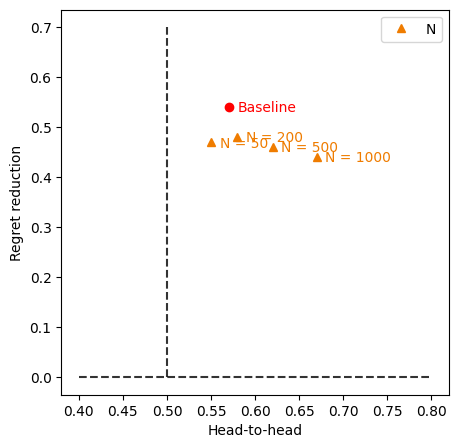

In [26]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5, 5))
# p_indices = [0,1,3,4,5]
# plt.plot(h2h_P_ante[p_indices], regret_P_ante[p_indices], color='green', marker = "*", label = 'p', linestyle = 'None')
# plt.text(h2h_P_ante[p_indices[0]] + 0.01, regret_P_ante[p_indices[0]] - 0.005, 'p='+str(num_feat_all[p_indices[0]]), color='green')
# plt.text(h2h_P_ante[p_indices[1]] + 0.01, regret_P_ante[p_indices[1]] - 0.005, 'p='+str(num_feat_all[p_indices[1]]), color='green')
# plt.text(h2h_P_ante[p_indices[2]] - 0.05, regret_P_ante[p_indices[2]] - 0.005, 'p='+str(num_feat_all[p_indices[2]]), color='green')
# plt.text(h2h_P_ante[p_indices[3]] - 0.05, regret_P_ante[p_indices[3]] - 0.005, 'p='+str(num_feat_all[p_indices[3]]), color='green')
# plt.text(h2h_P_ante[p_indices[4]] - 0.065, regret_P_ante[p_indices[4]] - 0.005, 'p='+str(num_feat_all[p_indices[4]]), color='green')

# plt.plot(h2h_d_ante[0], regret_d_ante[0], color='#003D7C', marker = "o", label = 'd', linestyle = 'None')
# # plt.plot(h2h_d[1], mci_d[1], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d_ante[1], regret_d_ante[1], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d_ante[2], regret_d_ante[2], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d_ante[4], regret_d_ante[4], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d_ante[5], regret_d_ante[5], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d_ante[6], regret_d_ante[6], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d_ante[7], regret_d_ante[7], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d_ante[8], regret_d_ante[8], color='#003D7C', marker = "o", linestyle = 'None')


# plt.text(h2h_d_ante[0] + 0.01, regret_d_ante[0] - 0.005, 'd = '+str(deg_all[0]), color='#003D7C')
# # plt.text(h2h_d[1] + 0.007, mci_d[1] - 0.003, 'd = 15', color='#003D7C')
# plt.text(h2h_d_ante[1] + 0.01, regret_d_ante[1] - 0.005, 'd = '+str(deg_all[1]), color='#003D7C')
# plt.text(h2h_d_ante[2] - 0.065, regret_d_ante[2] - 0.005, 'd = '+str(deg_all[2]), color='#003D7C')
# plt.text(h2h_d_ante[4] + 0.01, regret_d_ante[4] - 0.005, 'd = '+str(deg_all[4]), color='#003D7C')
# plt.text(h2h_d_ante[5] - 0.065, regret_d_ante[5] - 0.005, 'd = '+str(deg_all[5]), color='#003D7C')
# plt.text(h2h_d_ante[6] - 0.065, regret_d_ante[6] - 0.005, 'd = '+str(deg_all[6]), color='#003D7C')
# plt.text(h2h_d_ante[7] - 0.065, regret_d_ante[7] - 0.005, 'd = '+str(deg_all[7]), color='#003D7C')
# plt.text(h2h_d_ante[8] - 0.065, regret_d_ante[8] - 0.005, 'd = '+str(deg_all[8]), color='#003D7C')


plt.plot(h2h_N_ante[0], regret_N_ante[0], color='#EF7C00', marker = "^", label = 'N',linestyle = 'None')
plt.text(h2h_N_ante[1] + 0.01, regret_N_ante[1] - 0.01, 'Baseline', color='red')
# plt.plot(h2h_N[1], mci_N[1], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N_ante[2], regret_N_ante[2], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N_ante[3], regret_N_ante[3], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N_ante[4], regret_N_ante[4], color='#EF7C00', marker = "^",linestyle = 'None')
plt.text(h2h_N_ante[0] + 0.01, regret_N_ante[0] - 0.01, 'N = 50', color='#EF7C00')
# plt.text(h2h_N[1] + 0.005, mci_N[1] - 0.003, 'N = 100', color='#EF7C00')
plt.text(h2h_N_ante[2] + 0.01, regret_N_ante[2] - 0.01, 'N = 200', color='#EF7C00')
plt.text(h2h_N_ante[3] + 0.01, regret_N_ante[3] - 0.01, 'N = 500', color='#EF7C00')
plt.text(h2h_N_ante[4] + 0.01, regret_N_ante[4] - 0.01, 'N = 1000', color='#EF7C00')


# plt.plot(h2h_e_ante[0], regret_e_ante[0], color='grey', marker = "d", label = r'$\alpha$',linestyle = 'None')
# # plt.plot(h2h_alpha[1], mci_alpha[1], color='grey', marker = "d",linestyle = 'None')
# plt.plot(h2h_e_ante[2], regret_e_ante[2], color='grey', marker = "d",linestyle = 'None')
# plt.plot(h2h_e_ante[3], regret_e_ante[3], color='grey', marker = "d",linestyle = 'None')
# plt.text(h2h_e_ante[0] + 0.01, regret_e_ante[0] - 0.01, r'$\alpha$ = 0.25', color='grey')
# # plt.text(h2h_alpha[1] + 0.005, mci_alpha[1] - 0.005, r'$\alpha$ = 1', color='grey')
# plt.text(h2h_e_ante[2] - 0.075, regret_e_ante[2] - 0.01, r'$\alpha$ = 0.75', color='grey')
# plt.text(h2h_e_ante[3] + 0.01, regret_e_ante[3] - 0.01, r'$\alpha$ = 1.0', color='grey')

plt.vlines(0.5, 0.0, 0.7, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0.0, 0.4, 0.8, linestyle="dashed", alpha = 0.8,color = 'k')
plt.legend()

plt.xlabel('Head-to-head')
plt.ylabel('Regret reduction')

plt.plot(h2h_N_ante[1], regret_N_ante[1], color='red', marker = "o", linestyle = 'None')
# plt.annotate('Ridge vs. DDR', xy = (0.25,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

# fig.savefig(DataPath_parent+'DDR_vs_OLS_DPSN.eps', format='eps', bbox_inches="tight")
fig.savefig(Result_dir +'DDR_vs_OLS_diff_settings_ante.pdf', format='pdf', bbox_inches="tight")
plt.show()

In [20]:
h2h_N_ante

array([0., 0., 0., 0., 0.])